<a href="https://colab.research.google.com/github/dyjdlopez/demo-hybrid-quantum-nn/blob/main/demo_cudaq_hqn_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Quantum Neural Network with CUDA-Q

In [ ]:
!pip install matplotlib==3.8.4
!pip install torch==2.2.2
!pip install torchvision==0.17.0
!pip install scikit-learn==1.4.2
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb
!dpkg -i cuda-keyring_1.0-1_all.deb
!apt-get update
!apt-get -y install libcublas-11-8 libcusolver-11-8 cuda-cudart-11-8

%pip install cuda-quantum==0.7.1

  Using cached torch-2.2.2-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 2.2.2 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.2.2 which is incompatible.
torchvision 0.18.0+cu121 requires torch==2.3.0, but you have torch 2.2.2 which is incompatible.
  Using cached torchvision-0.17.0-cp310-cp310-manylinux1_x86_64.whl (6.9 MB)
  Using cached torch-2.2.0-cp310-cp310-manylinux1_x86_64.wh

In [ ]:
import cudaq
from cudaq import spin

import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torchvision

from sklearn.model_selection import train_test_split

torch.manual_seed(22)
cudaq.set_random_seed(44)

In [ ]:
# Set CUDAQ and PyTorch to run on either CPU or GPU.

# device = torch.device('cpu')
# cudaq.set_target("qpp-cpu")

cudaq.set_target("nvidia")
device = torch.device("cuda:0")

## 1. Quantum Circuit
We build a quantum circuit with n_qubits parameterized quantum kernel. A Hadarmad opertor and a rotational operator are applied on all qubits. The result returned is the expectation value. This quantum circuit can be used as a alternative to the softmax layer in classification problem. This will provides us a simple interface for interaction with the quantum circuit later in the classical part.

In [ ]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit
    """

    def __init__(self, n_qubits):

        kernel, theta = cudaq.make_kernel(list)

        self.kernel = kernel

        self.theta = theta

        qubits = kernel.qalloc(n_qubits)

        self.kernel.h(qubits)

        kernel.ry(theta[0], qubits)


    def run(self, thetas):

        expectation = cudaq.observe(self.kernel, spin.z(0), thetas).expectation()

        return np.array([expectation])

In [ ]:
simulator = cudaq.set_target('nvidia')

circuit = QuantumCircuit(1)
circuit.run([6])

array([0.27941549])

##2. Quantum function as a Pytorch Module
Now we create the quantum function on `torch.Function` class and hybrid module based on `torch.nn.Module`. In this Quantum Function, we define the forward pass and the backward pass which is essential for training. The gradient is computed with parameter shift. The hybrid module is composed by the quantum circuit and the hybrid function.

In [ ]:
class QuantumFunction(Function):
    """Allows the quantum circuit to input data, output expectation values
    and calculate gradients of variational parameters via finite difference"""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        @cudaq.kernel
        def kernel(qubit_count: int, thetas: np.ndarray):

            qubits = cudaq.qvector(qubit_count)

            ry(thetas[0], qubits[0])
            rx(thetas[1], qubits[0])

        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

    def run(self, theta_vals: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        #If running on GPU, thetas is a torch.tensor that will live on GPU memory. The observe function calls a .tolist() method on inputs which moves thetas from GPU to CPU.

        qubit_count = [self.qubit_count for _ in range(theta_vals.shape[0])]

        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count,
                                theta_vals)

        exp_vals = [results[i].expectation() for i in range(len(results))]
        exp_vals = torch.Tensor(exp_vals).to(device)

        return exp_vals

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate expectation value.
        exp_vals = ctx.quantum_circuit.run(thetas).reshape(-1, 1)

        ctx.save_for_backward(thetas, exp_vals)

        return exp_vals

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference"""

        thetas, _ = ctx.saved_tensors

        gradients = torch.zeros(thetas.shape, device=device)

        for i in range(thetas.shape[1]):

            thetas_plus = thetas.clone()
            thetas_plus[:, i] += ctx.shift
            exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)

            thetas_minus = thetas.clone()
            thetas_minus[:, i] -= ctx.shift
            exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)

            gradients[:, i] = (exp_vals_plus - exp_vals_minus) / (2 * ctx.shift)

        gradients = torch.mul(grad_output, gradients)

        return gradients, None, None

##3. Dataset Preparation

In [ ]:
def prepare_data(target_digits, sample_count, test_size):
    """Load and prepare the MNIST dataset to be used

    Args:
        target_digits (list): digits to perform classification of
        sample_count (int): total number of images to be used
        test_size (float): percentage of sample_count to be used as test set, the remainder is the training set

    Returns:
        dataset in train, test format with targets

    """

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307), (0.3081))])

    dataset = datasets.MNIST("./data",
                             train=True,
                             download=True,
                             transform=transform)

    # Filter out the required labels.
    idx = (dataset.targets == target_digits[0]) | (dataset.targets
                                                   == target_digits[1])
    dataset.data = dataset.data[idx]
    dataset.targets = dataset.targets[idx]

    # Select a subset based on number of datapoints specified by sample_count.
    subset_indices = torch.randperm(dataset.data.size(0))[:sample_count]

    x = dataset.data[subset_indices].float().unsqueeze(1).to(device)

    y = dataset.targets[subset_indices].to(device).float().to(device)

    # Relabel the targets as a 0 or a 1.
    y = torch.where(y == min(target_digits), 0.0, 1.0)

    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=test_size /
                                                        100,
                                                        shuffle=True,
                                                        random_state=42)

    return x_train, x_test, y_train, y_test

##4. Dataset Splicing

In [ ]:
# Classical parameters.

sample_count = 1000  # Total number of images to use.
target_digits = [5, 6]  # Hand written digits to classify.
test_size = 30  # Percentage of dataset to be used for testing.
classification_threshold = 0.5  # Classification boundary used to measure accuracy.
epochs = 10  # Number of epochs to train for.

# Quantum parmeters.

qubit_count = 1
hamiltonian = spin.z(0)  # Measurement operator.
shift = torch.tensor(torch.pi / 2)  # Magnitude of parameter shift.

In [ ]:
x_train, x_test, y_train, y_test = prepare_data(target_digits, sample_count,
                                                test_size)

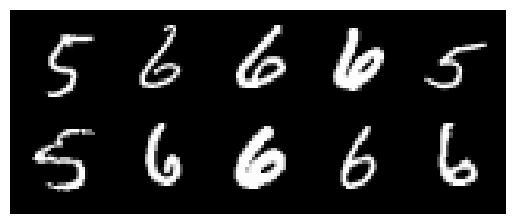

In [ ]:
# Plot some images from the training set to visualise.

grid_img = torchvision.utils.make_grid(x_train[:10].cpu(),
                                       nrow=5,
                                       padding=3,
                                       normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

##6. Creating a Hybrid Quantum Structure


In [ ]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit into a quantum layer adhering PyTorch convention"""

    def __init__(self, qubit_count: int, hamiltonian, shift: torch.tensor):
        super(QuantumLayer, self).__init__()

        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input):

        result = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return result

In [ ]:
class Hyrbid_QNN(nn.Module):
    """Structure of the hybrid neural network with classical fully connected layers and quantum layers"""

    def __init__(self):
        super(Hyrbid_QNN, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.25)

        # The 2 outputs from PyTorch fc5 layer feed into the 2 variational gates in the quantum circuit.
        self.quantum = QuantumLayer(qubit_count, hamiltonian, shift)

    def forward(self, x):

        x = x.view(-1, 28 * 28)  # Turns images into vectors.

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)

        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)

        # Quantum circuit outputs an expectation value which is fed into the sigmoid activation function to perform classification.
        x = torch.sigmoid(self.quantum(x))

        return x.view(-1)

##7. Training and Evaluation

In [ ]:
def accuracy_score(y, y_hat):
    return sum((y == (y_hat >= classification_threshold))) / len(y)

In [ ]:
from tqdm.notebook import tqdm_notebook as tqdm
hybrid_model = Hyrbid_QNN().to(device)

optimizer = optim.Adadelta(hybrid_model.parameters(),
                           lr=0.001,
                           weight_decay=0.8)

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()
for epoch in tqdm(range(epochs)):

    optimizer.zero_grad()

    y_hat_train = hybrid_model(x_train).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    hybrid_model.eval()
    with torch.no_grad():

        y_hat_test = hybrid_model(x_test).to(device)

        test_cost = loss_function(y_hat_test, y_test).to(device)

        testing_accuracy.append(accuracy_score(y_test, y_hat_test))
        testing_cost.append(test_cost.item())

  0%|          | 0/10 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError
TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

TypeError: object of type 'NoneType' has no len()

During handling of the above exception, another exception occurred:

AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

AssertionError
TypeError: can't convert cuda:0 device type

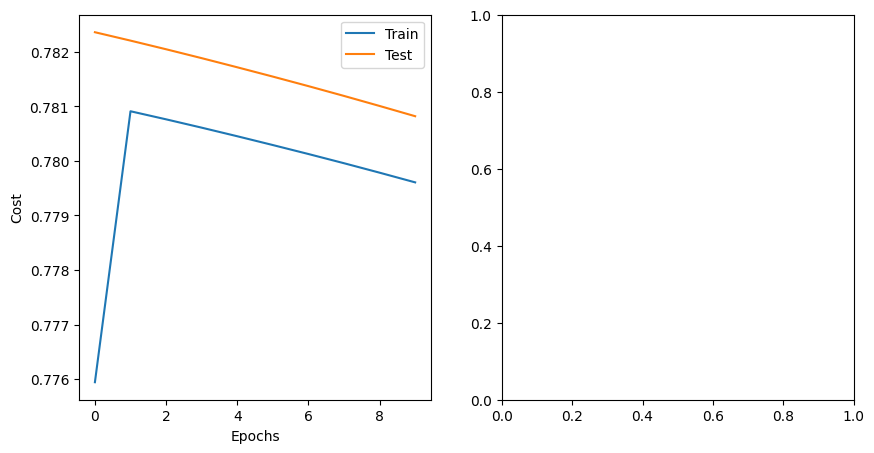

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_cost, label='Train')
plt.plot(testing_cost, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Train')
plt.plot(testing_accuracy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()